# Deep learning with Differential Privacy - Main script. Author: Reinier Vos (4663160 TUD)

## Imports

In [7]:
try:
  # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass
  
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Normalization

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
from tqdm import tqdm # gives progress bar when loading
import tensorflow_datasets as tfds
import matplotlib.ticker as mticker
import scipy.stats as sc
import time
from sklearn.preprocessing import StandardScaler
import random
# verbosity 
#tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.autograph.set_verbosity(0)

# QUESTIONS/TO-DO
- minibatches for sgd, to speed up optimization? - https://github.com/tensorflow/privacy/blob/master/tutorials/mnist_dpsgd_tutorial.py 
-
-
-
-
-

# Script Main Parameters

In [35]:
# main
seed = 2
std_pca = 7 #16 #4 # std for pca
std_sgd = 4 # std for dp_sgd
batch_size = 600 
lr_sgd = 0.05 # [0.01,0.07] stable, best at 0.05
C = 4 # gradient clipping bound
gs = batch_size

# moment accountant specific
parameters_ma = {"maxOrder":32,
                 "sigma": std_sgd,
                 "q": batch_size/60000,
                 "T":400}
debug = True
#'''
deltaFixed = False
epsFixed= True
epsilon = 2
th_delta = 100#10**-5 # epsilon fixed
'''
deltaFixed = True 
epsFixed= False
delta = 10e-5
th_epsilon = 2 # delta fixed
'''
allParameters = {**parameters_ma,
                'seed' : seed,
                'std_pca' :std_pca, 
                'std_sgd' : std_sgd,
                'batch_size' : batch_size, 
                'lr_sgd' : lr_sgd, 
                'C' : C, 
                'deltaFixed' : deltaFixed, 
                'epsFixed': epsFixed, 
                'epsilon' : epsilon, 
                'th_delta' : th_delta, 
}
'''
allParameters = {**parameters_ma,
                'seed' = seed,
                'std_pca' =std_pca, 
                'std_sgd' = std_sgd,
                'batch_size' = batch_size, 
                'lr_sgd' = lr_sgd, 
                'C' = C, 
                'deltaFixed' = deltaFixed, 
                'epsFixed'= epsFixed, 
                'delta' = delta, 'th_epsilon' = th_epsilon, 
}
'''
batches = 100
np.random.seed(seed)  

Maxorder = 32, with order array:
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32]
keeping epsilon fixed
moment accountant setup complete
Delta fixed = False| Last delta = 7.3130754258017764e-06
Epsilon fixed = True| Last epsilon = 2
Fixed parameter will not be plotted 
 NOTE: Iteration arrays are returned


(array([1.61157896e-28, 1.61938465e-28, 1.62722815e-28, ...,
        7.28717560e-06, 7.30011403e-06, 7.31307543e-06]),
 array([2, 2, 2, ..., 2, 2, 2]),
 array([32, 32, 32, ..., 17, 17, 17]))

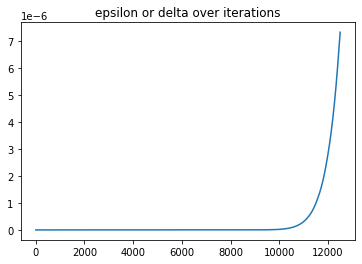

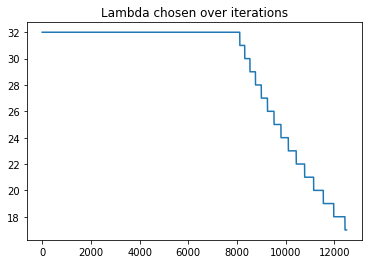

In [36]:
accountant = moment_accountant(seed, parameters_ma, deltaFixed = deltaFixed, epsFixed= epsFixed, debug = debug, epsilon = epsilon, th_delta = th_delta)
#for i in range(12500):
for i in range(80000):
    accountant.compute_deltaEps()
accountant.plot_traces()

## Load and Preprocess Data
We frist load the MNIST dataset using Tensorflow Datasets. This dataset has 28 x 28 grayscale images of digits belonging to 10 classes.


train_data, info = tfds.load("mnist", split = "train", with_info = True, data_dir='./data/', download=True)
test_data = tfds.load("mnist", split = "test", data_dir='./data/', download=True)

In [9]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [10]:
# reshape
x_train = x_train.reshape(x_train.shape[0],784)
x_test = x_test.reshape(x_test.shape[0],784)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

covar = tf.cast(tf.einsum('ji,jk->ik', x_train, x_train), 'float32') # covariance matrix used for pca

In [11]:
# get batches
indices = np.arange(0,len(x_train))
np.random.shuffle(indices)

x_train_batches = np.array_split(x_train[indices,:], batches)
y_train_batches = np.array_split(y_train[indices], batches)
train = list(zip(x_train_batches, y_train_batches))
x_test_batches = np.array_split(x_test, batches)
y_test_batches = np.array_split(y_test, batches)
test = list(zip(x_test_batches, y_test_batches))

In [12]:
class_names = ["0","1","2","3","4","5","6","7","8","9","10"]

Next, you normalize the images by dividing them by 255.0 so as to make the pixels fall in the range (0, 1). You also reshape the data so as to flatten the 28 x 28 pixel array into a flattened 784 pixel array.

def format_image(data):        
    image = data["image"]
    image = tf.reshape(image, [-1]) ## same as keras.layers.Flatten()
    image = tf.cast(image, 'float32')
    image = image / 255.0
    image = tf.math.l2_normalize(image, axis=-1)
    #image = image / 255.0
    return image, data["label"]

train_data = train_data.map(format_image) # preprocesses
test_data = test_data.map(format_image) # preprocesses

Now you shuffle and batch your training and test datasets before feeding them to the model.

#train_data = tf.data.Dataset(x_train)
#test_data = tf.data.Dataset(x_test)

train = train_data.shuffle(buffer_size=batch_size*4).batch(batch_size) # memory management - batches are drawn from 1024 selected - if selected samples are replaced by unseen samples

test =  test_data.batch(batch_size=batch_size)


## Define the Model - DP for MNIST as in paper


### DP PCA layer

In [13]:
class DP_PCA(tf.keras.layers.Layer):
    def __init__(self, pca_components, seed, std, covar):
        super(DP_PCA, self).__init__()
        self.pca_components = pca_components
        self.seed = seed
        self.std = std
        self.covar = covar

    def build(self, input_shape):
        a = 1 # placeholder

    def call(self, inputs):
        #inputs = tf.linalg.normalize(inputs, ord=2, axis=-1)
        #inputs = tf.math.l2_normalize(inputs, axis=-1)
        #covar = tf.einsum('ji,jk->ik', inputs, inputs)
        #print(tf.shape(covar))
        # add noise
        covar = self.covar # copy
        shape = tf.shape(covar)
        noise = tf.random.normal(shape, mean = 0, stddev = self.std, dtype=tf.dtypes.float32, seed=self.seed)
        covar += noise
        # add vectors
        e_values, e_vectors = tf.linalg.eigh(covar)
        return tf.einsum('ij,jk->ik', inputs, e_vectors[:,-self.pca_components:])
        #return tf.einsum('ji,ik->jk', inputs, e_vectors[:,-self.pca_components:])

### Base model

In [14]:
def base_model():
    inputs = tf.keras.Input(shape=(784,), name='digits')
    #x = tf.keras.layers.Normalization(axis=-1)(inputs) # normalization
    x = DP_PCA(60, seed, std_pca, covar)(inputs)
    #x = DP_PCA(60, seed, std_pca)(x)
    #x = tf.keras.layers.Dense(1000, activation='relu', name='dense_1')(inputs)
    x = tf.keras.layers.Dense(1000, activation='relu', name='dense_1')(x)
    outputs = tf.keras.layers.Dense(10, activation='softmax', name='predictions')(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.summary()
    return model

model = base_model()
z = np.random.rand(28*28)
z = tf.constant(z)
zout = model(z)

## Define Optimizer and Loss Function


In [15]:
optimizer = tf.keras.optimizers.SGD(learning_rate = lr_sgd) # [0.01,0.07] stable, best at 0.05
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.compat.v1.losses.Reduction.NONE)
#loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
#loss_object = lambda t,p : tf.reduce_sum(tf.math.square(tf.squeeze(tf.cast(tf.one_hot(t, 10), tf.float32))- p), axis = -1)
#loss_object = lambda t,p : tf.reduce_sum(tf.math.square(tf.squeeze(tf.cast(tf.one_hot(t, 10), tf.float32))- p), axis = -1)


y1 = tf.constant([[1],[3]])
x1 = tf.constant([[0,0.1,0.2,0.1],[0,0.1,0.2,0.1]])
print(tf.squeeze(tf.cast(tf.one_hot(y1, 4), tf.float32)))

loss_object = lambda t,p : tf.reduce_sum(tf.math.square(tf.squeeze(tf.cast(tf.one_hot(t, 4), tf.float32))- p), axis = -1) # tf.reduce_sum(tf.math.square(tf.math.subtract(tf.cast(tf.one_hot(t, 4), tf.float32),p)), axis = -1) 
l = loss_object(y1, x1)
l

## Define Metrics & Loss functions

In [16]:
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

## Moment accountant class

In [34]:
class moment_accountant():
    def __init__(self,seed, params: dict,deltaFixed = False, epsFixed= False, debug = False, **kwargs):
        
        # moment accountant hyperparameters
        self.mixN = 10000 # samples for mixture of moment arrays
        self.debug = debug
        self.seed = seed
        
        # constants 
        self.maxOrder = params["maxOrder"] # maximum moment order 
        self.lambd = np.arange(1,self.maxOrder+1)
        #self.lambd = np.array([0])
        self.lambdaN = len(self.lambd) # number of lambdas to check
        print(f"Maxorder = {self.maxOrder}, with order array:")
        print(self.lambd)
        self.sigma = params["sigma"]
        self.q = params["q"]
        self.T = params["T"]
        
        # booleans 
        self.deltaFixed = deltaFixed
        self.epsFixed = epsFixed
        
        if self.deltaFixed:
            if self.epsFixed:
                raise Exception("Choose ONLY epsilon or delta as fixed")
            # in case delta is held fixed
            print("keeping delta fixed")
            self.delta = kwargs["delta"]
            self.th_epsilon = kwargs["th_epsilon"]
        elif self.epsFixed:
            # in case epsilon is held fixed
            print("keeping epsilon fixed")
            self.epsilon = kwargs["epsilon"]
            self.th_delta = kwargs["th_delta"]
        else:
            raise Exception("Choose EITHER epsilon or delta as fixed")
        
        #self.e1_mu0, self.e1_mu, self.e2_mu0, self.e2_mu = self._setup_mixNormNP() # obtain random sample arrays NUMPY
        self.e1_mu0, self.e1_mu, self.e2_mu0, self.e2_mu = self._setup_mixNormTF() # obtain random sample arrays TENSORFLOW
        self.alpha = self._compute_moment(self.lambd)
        
        # initializations 
        self.alphaSum = 0 # moment
        self.lambdArgmin = []
        self.iterations = 0
        self.deltaList = []
        self.epsList = []
        # =================================
        print("moment accountant setup complete")
        
    def _setup_mixNormTF(self):
        '''
        Mixture of gaussians by tensorflow, so no assumptions used
        https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/Mixture
        '''
        
        '''
        CHECKED - WORKING CORRECTLY
        '''
        # setup normal dis & mixture of normals arrays
        np.random.seed(self.seed) # set seed
        mu_0 = np.random.normal(0, self.sigma, (self.mixN))
        # analytical mean & var for mix
        
        # setup gaussian mixture
        dismix_mu = tfp.distributions.Mixture(cat=tfp.distributions.Categorical(probs=[1.-self.q, self.q]),
                                    components=[tfp.distributions.Normal(loc=0., scale=self.sigma),
                                                tfp.distributions.Normal(loc=1., scale=self.sigma)])
        mu = dismix_mu.sample(sample_shape=(self.mixN), seed=self.seed).numpy()

        # find pdf values for z's 
        e1_mu0 = sc.norm.pdf(mu_0,loc = 0, scale = self.sigma)
        e1_mu = dismix_mu.prob(mu_0).numpy()
        
        e2_mu0 = sc.norm.pdf(mu,loc = 0, scale = self.sigma)
        e2_mu = dismix_mu.prob(mu).numpy()

        return e1_mu0, e1_mu, e2_mu0, e2_mu
                            
    def _compute_moment(self, lambd: np.array):
        '''
        CHECKED - WORKING CORRECTLY
        '''
        # computes unbiased expectation for E1 & E2, then the moment alpha 
        lambd = np.broadcast_to(np.expand_dims(lambd, -1), (self.lambdaN, self.mixN)) # broadcast
        #E1 = 1/self.mixN*np.sum(np.transpose(np.power(np.transpose(self.mu_0/self.mu),lambd)), axis = 0)
        #E2 = 1/self.mixN*np.sum(np.transpose(np.power(np.transpose(self.mu/self.mu_0),lambd)), axis = 0)
        E1 = np.nanmean(np.transpose(np.power(np.transpose(self.e1_mu0/self.e1_mu),lambd)), axis = 0)
        '''
        note that due to setup E1 will always be < 1 since denom > num always
        '''
        E2 = np.nanmean(np.transpose(np.power(np.transpose(self.e2_mu/self.e2_mu0),lambd)), axis = 0)
        '''
        note that due to setup E2 will always be > 1 since denom < num always
        '''
        #alpha = np.log(np.maximum(E1,E2))
        alpha = np.log(np.maximum(E1,E2))
        return alpha
    
    def compute_deltaEps(self):
        # tail bound
        #alpha = self._compute_moment(self.lambd) + self.alpha # note that this is the log moment!
        alpha = self.alphaSum + self.alpha # note that this is the log moment!
        self.alphaSum = alpha # update moment
        if self.epsFixed:
            # epsilon is kept fixed, compute delta
            epsilon = self.epsilon
            delta = np.min(np.exp(alpha-self.lambd*epsilon))
            # TODO remove inf or nan <- does not seem necessary
            if self.debug:
                ind = np.argmin(np.exp(alpha-self.lambd*epsilon))
                self.lambdArgmin.append(self.lambd[ind])
        if self.deltaFixed:
            # delta is kept fixed, compute epsilon
            delta = self.delta
            epsilon = (alpha-np.log(delta))/self.lambd
            if self.debug:
                ind = np.argmin(epsilon)
                self.lambdArgmin.append(self.lambd[ind])
            epsilon = np.min(epsilon)
            # TODO remove inf or nan <- does not seem necessary
        self.epsList.append(epsilon)
        self.deltaList.append(delta)
        return delta, epsilon
    
    def check_thresholds(self, delta: float, epsilon: float):
        go = True
        if self.epsFixed:
            if self.th_delta < delta: 
                # delta threshold exceeded
                go = False
        if self.deltaFixed:
            if self.th_epsilon < epsilon:
                # epsilon threshold exceeded
                go = False
        return go
    
    def plot_traces(self):
        if len(self.epsList) == 0:
            raise Exception("Apply iterations on accountant instance before calling this function")
        elif not self.debug:
            raise Exception("Debug was set to false, thus not all relevant data was collected")
        else:
            # gather data
            epsilon = np.array(self.epsList)
            delta = np.array(self.deltaList)
            lambdas = np.array(self.lambdArgmin)
            print(f"Delta fixed = {self.deltaFixed}| Last delta = {delta[-1]}")
            print(f"Epsilon fixed = {self.epsFixed}| Last epsilon = {epsilon[-1]}")
            print("Fixed parameter will not be plotted \n NOTE: Iteration arrays are returned")
            # plotting
            iterations = np.arange(0,len(epsilon))
            plt.figure()
            if self.deltaFixed:
                plt.plot(iterations,epsilon, label = 'epsilon')
            else:
                plt.plot(iterations,delta, label = 'delta')
            #plt.legend(loc='upper left')
            plt.title("epsilon or delta over iterations")
            
            plt.figure()
            plt.plot(iterations,lambdas)
            plt.title("Lambda chosen over iterations")
            
        return delta, epsilon, lambdas


accountant = moment_accountant(seed, parameters_ma, deltaFixed = deltaFixed, epsFixed= epsFixed, debug = debug, epsilon = epsilon, th_delta = th_delta)
for i in range(0,20):
    print(accountant.compute_deltaEps())
    #print(accountant.alphaSum)
accountant.plot_traces()

# TODO/QUESTIONS
- Is the following assumption true: the moment accountant random variable is independent of the rest of the system (offline), that said it is only connected to the system by its continuous call to it (causing the moment to grow)
- maxorder? 32 and also can it be floats?
- ASSUMPTION: q is so small that essentially the pdf_mu0 distribution stands? is this correct?

## Differential privary variant of SGD


In [18]:
class DP_SGD:
    def __init__(self, lr = 0.01, sigma = 0.2, gs = 10, C = 1, seed = 2): # TODO; check defaults
        self.lr = lr # learning rate
        self.sigma = sigma # sigma, noise scale
        self.gs = gs # group size
        self.C = C # gradient norm bound
        self.seed = seed
        self.std = sigma*C # for noise addition
        #self.loss_object = ? # define this here
        
    def apply_gradients(self, optimizer, model, loss_object, x, y):

        #n = tf.shape(x).numpy()
        ## run loop
        with tf.GradientTape(persistent = True) as tape:
            y_pred = model(x)
            loss = loss_object(y, y_pred)
            loss_red = tf.reduce_sum(loss, axis = 0)
            
            
        #########
        # MAIN PROBLEM: I only get a single set of gradients even if i have a loss function which outputs loss for every sample
        # do you want me to parallelize this myself
        ########
        ## obtain gradients    
        #grad = tape.batch_jacobian(loss, model.trainable_weights)
        grad = tape.jacobian(loss, model.trainable_weights, parallel_iterations = None, experimental_use_pfor= False)
        
        ## clip gradients per layer
        for l in range(len(grad)):
            #clipper = tf.norm(grad[l], ord = 2, axis = 0)
            dims = len(tf.shape(grad[l]))
            clipper = tf.math.square(grad[l])
            
            if dims > 2:
                # kernel layers
                clipper = tf.reduce_sum(clipper, axis = [1,2])
            else:
                # bias layer
                clipper = tf.reduce_sum(clipper, axis = -1)
                
            clipper = tf.math.sqrt(clipper)
            clipper = tf.math.maximum(tf.constant([1], dtype = tf.dtypes.float32),clipper/self.C)
            if dims > 2:
                # kernel layers
                clipper = tf.broadcast_to(tf.expand_dims(tf.expand_dims(clipper, -1), -1),tf.shape(grad[l]))
            else:
                # bias layer
                clipper = tf.broadcast_to(tf.expand_dims(clipper, -1),tf.shape(grad[l]))
            grad[l] = tf.math.divide(grad[l],clipper) # override
                
        ## add noise
        for l in range(len(grad)): # loop over layers
            grad_red = tf.math.reduce_sum(grad[l], axis = 0)
            shape = tf.shape(grad_red)
            noise = tf.random.normal(shape, mean = 0, stddev = self.std, dtype=tf.dtypes.float32, seed=self.seed)
            grad[l] = tf.add(grad_red, noise)/self.gs
            


        ## descent
        #print(grad)
        '''
        print(f'HELOO={len(grad)}')
        print(f'HELOO={len(model.trainable_weights)}')
        ga = []
        ma = []
        print(type(model.trainable_weights))
        for l in range(len(model.trainable_weights)):
            ga.append(tf.shape(grad[l]).numpy())
            ma.append(tf.shape(model.trainable_weights[l]).numpy())
        zipp = list(zip(ga,ma))
        print(zipp)
        
        #print(model.trainable_weights)
        '''
        
        optimizer.apply_gradients(zip(grad,model.trainable_weights))
            
        ## collect
    
        return y_pred,loss_red 
        
        

# CLIPTOTAL VARIANT
class DP_SGD:
    def __init__(self, lr = 0.01, sigma = 0.2, gs = 10, C = 1, seed = 2): # TODO; check defaults
        self.lr = lr # learning rate
        self.sigma = sigma # sigma, noise scale
        self.gs = gs # group size
        self.C = C # gradient norm bound
        self.seed = seed
        self.std = sigma*C # for noise addition
        #self.loss_object = ? # define this here
        
    def apply_gradients(self, optimizer, model, loss_object, x, y):

        #n = tf.shape(x).numpy()
        ## run loop
        with tf.GradientTape(persistent = True) as tape:
            y_pred = model(x)
            loss = loss_object(y, y_pred)
            loss_red = tf.reduce_sum(loss, axis = 0)
            
            
        #########
        # MAIN PROBLEM: I only get a single set of gradients even if i have a loss function which outputs loss for every sample
        # do you want me to parallelize this myself
        ########
        ## obtain gradients    
        #grad = tape.batch_jacobian(loss, model.trainable_weights)
        grad = tape.jacobian(loss, model.trainable_weights, parallel_iterations = None, experimental_use_pfor= False)
        clipTotal = tf.constant([0], dtype = tf.dtypes.float32)
        
        ## clip gradients per layer
        for l in range(len(grad)):
            #clipper = tf.norm(grad[l], ord = 2, axis = 0)
            dims = len(tf.shape(grad[l]))
            clipper = tf.math.square(grad[l])
            
            if dims > 2:
                # kernel layers
                clipper = tf.reduce_sum(clipper, axis = [1,2])
            else:
                # bias layer
                clipper = tf.reduce_sum(clipper, axis = -1)
                
            clipTotal = tf.add(clipTotal, clipper)
            
        clipTotal = tf.math.sqrt(clipTotal)
        clipTotal = tf.math.maximum(tf.constant([1], dtype = tf.dtypes.float32),clipTotal/self.C)
                
        ## add noise
        for l in range(len(grad)): # loop over layers
            dims = len(tf.shape(grad[l]))
            if dims > 2:
                # kernel layers
                clipper = tf.broadcast_to(tf.expand_dims(tf.expand_dims(clipTotal, -1), -1),tf.shape(grad[l]))
            else:
                # bias layer
                clipper = tf.broadcast_to(tf.expand_dims(clipTotal, -1),tf.shape(grad[l]))
            grad[l] = tf.math.divide(grad[l],clipper) # override
            
            grad_red = tf.math.reduce_sum(grad[l], axis = 0)
            shape = tf.shape(grad_red)
            noise = tf.random.normal(shape, mean = 0, stddev = self.std, dtype=tf.dtypes.float32, seed=self.seed)
            grad[l] = tf.add(grad_red, noise)/self.gs
            
        ## descent
        optimizer.apply_gradients(zip(grad,model.trainable_weights))
            
        ## collect
    
        return y_pred,loss_red 

## Building Training Loop

In [13]:
def apply_gradient(optimizer, model, x, y):
    with tf.GradientTape() as tape:
        logits = model(x)
        loss_value = loss_object(y_true=y, y_pred=logits)

    gradients = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(gradients, model.trainable_weights)) # ZIP ENSURES THAT GRADIENTS IS APPLIED TO EVERY LAYER CORRECTLY (SINCE EVERY LAYER HAS W & b != not 1 variable)

    return logits, loss_value

In [14]:
def train_data_for_one_epoch(dp_sgd, optimizer, model, loss_object, moment_accountant):
    losses = []
    pbar = tqdm(total=len(list(enumerate(train))), position=0, leave=True, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} ') # progress bar
    go = True
    step = 0 
    for x_batch_train, y_batch_train in train:
        step += 1
        logits, loss_value = dp_sgd.apply_gradients(optimizer, model, loss_object, x_batch_train, y_batch_train)
        #logits, loss_value = apply_gradient(optimizer, model, x_batch_train, y_batch_train)
        delta, eps = moment_accountant.compute_deltaEps()
        
        losses.append(loss_value)

        train_acc_metric(y_batch_train, logits)
        pbar.set_description("Training loss for step %s: %.4f" % (int(step), float(loss_value)))
        pbar.update()
        
        if not moment_accountant.check_thresholds(delta, epsilon):
            go = False
            break
    print(f"Delta = {delta} | Epsilon = {epsilon}")
    return losses, go

At the end of each epoch you have to validate the model on the test dataset. The following function calculates the loss on test dataset and updates the states of the validation metrics.

In [15]:
def perform_validation():
    losses = []
    for x_val, y_val in test:
        val_logits = model(x_val)
        val_loss = loss_object(y_val, val_logits)
        #val_loss = tf.reduce_sum(val_loss, axis = 0).numpy()
        losses.append(val_loss)
        val_acc_metric(y_val, val_logits)
    return losses

Maxorder = 32, with order array:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32]
keeping epsilon fixed
moment accountant setup complete
Delta fixed = False| Last delta = 7.3130754258017764e-06
Epsilon fixed = True| Last epsilon = 2
Fixed parameter will not be plotted 
 NOTE: Iteration arrays are returned


(array([1.61157896e-28, 1.61938465e-28, 1.62722815e-28, ...,
        7.28717560e-06, 7.30011403e-06, 7.31307543e-06]),
 array([2, 2, 2, ..., 2, 2, 2]),
 array([32, 32, 32, ..., 17, 17, 17]))

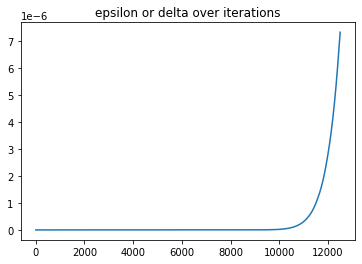

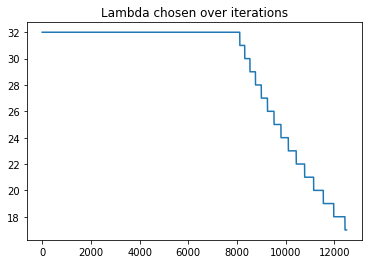

In [19]:
accountant = moment_accountant(seed, parameters_ma, deltaFixed = deltaFixed, epsFixed= epsFixed, debug = debug, epsilon = epsilon, th_delta = th_delta)
for i in range(12500):
    accountant.compute_deltaEps()
accountant.plot_traces()

In [16]:
## INITIALIZE 
model = base_model()
model.layers[2].trainable = False # pca layer
DPSGD = DP_SGD(lr_sgd,std_sgd, gs, C, seed)
if epsFixed: 
    print("\n Epsilon kept fixed \n")
    accountant = moment_accountant(seed, parameters_ma, deltaFixed = deltaFixed, epsFixed= epsFixed, debug = debug, epsilon = epsilon, th_delta = th_delta)
else:
    print("\n Delta kept fixed \n")
    #delta fixed
    accountant = moment_accountant(seed, parameters_ma, deltaFixed = deltaFixed, epsFixed= epsFixed, debug = debug, delta = delta, th_epsilon = th_epsilon)

# Iterate over epochs.
epochs = 110 #18
epochs_val_losses, epochs_train_losses = [], []
for epoch in range(epochs):
    print('Start of epoch %d' % (epoch,))

    losses_train, go = train_data_for_one_epoch(DPSGD, optimizer, model, loss_object, accountant)
    train_acc = train_acc_metric.result()

    losses_val = perform_validation()
    val_acc = val_acc_metric.result()

    losses_train_mean = np.mean(losses_train)
    losses_val_mean = np.mean(losses_val)
    epochs_val_losses.append(losses_val_mean)
    epochs_train_losses.append(losses_train_mean)

    print('\n Epoch %s: Train loss: %.4f  Validation Loss: %.4f, Train Accuracy: %.4f, Validation Accuracy %.4f' % (epoch, float(losses_train_mean), float(losses_val_mean), float(train_acc), float(val_acc)))

    train_acc_metric.reset_states()
    val_acc_metric.reset_states()
    if not go:
        print(f"\n Stopping due to privacy loss at epoch {epoch}/{epochs} \n")
        break


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 digits (InputLayer)         [(None, 784)]             0         
                                                                 
 dp_pca (DP_PCA)             (None, 60)                0         
                                                                 
 dense_1 (Dense)             (None, 1000)              61000     
                                                                 
 predictions (Dense)         (None, 10)                10010     
                                                                 
Total params: 71,010
T

  0%|                                                                                                          | 0/100 


 Epsilon kept fixed 

Maxorder = 32, with order array:
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32]
keeping epsilon fixed
moment accountant setup complete
Start of epoch 0


Training loss for step 100: 430.8535: 100%|██████████████████████████████████████████████████████████████████| 100/100 

Delta = 1.4758626944157784e-07 | Epsilon = 0.5


  0%|                                                                                                          | 0/100 


 Epoch 0: Train loss: 771.5447  Validation Loss: 0.7332, Train Accuracy: 0.6049, Validation Accuracy 0.7786
Start of epoch 1


Training loss for step 3: 489.6414:   3%|██                                                                    | 3/100 

KeyboardInterrupt: 

## Evaluate Model

### Plots for Evaluation

In [ ]:
def plot_metrics(train_metric, val_metric, metric_name, title, ylim=5):
    plt.title(title)
    #plt.ylim(0,ylim)
    plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
    x = np.arange(1,len(train_metric)+1)
    plt.plot(x,train_metric,color='blue',label=metric_name)
    plt.plot(x,val_metric,color='green',label='val_' + metric_name)
    plt.legend()

plot_metrics(epochs_train_losses, epochs_val_losses, "Loss", "Loss", ylim=10.0)

# Saving files

In [ ]:
clock = time.localtime(time.time())
runName = f'run_d{clock.tm_mday}h{clock.tm_hour}m{clock.tm_min}'
print(runName)
pathName = f'./models/{runName}'
model.save(pathName)
with open(f'./models/{runName}/{runName}_parameters.txt', 'w') as f:
    print(allParameters, file=f)
with open(f'./models/{runName}/delta_epsilon_lambda_.npy', 'wb') as f:
    np.save(f, np.array(accountant.deltaList))
    np.save(f, np.array(accountant.epsList))
'''
# get arrays back
with open(f'./models/{runName}/delta_epsilon_lambda_.npy', 'rb') as f:
    deltas = np.load(np.array(accountant.deltaList))
    epsilons = np.load(np.array(accountant.epsList))
'''

This function displays a row of images with their predictions and true labels.

# Utility function
## utility to display a row of images with their predictions and true labels
def display_images(image, predictions, labels, title, n):

    display_strings = [str(i) + "\n\n" + str(j) for i, j in zip(predictions, labels)] 

    plt.figure(figsize=(17,3))
    plt.title(title)
    plt.yticks([])
    plt.xticks([28*x+14 for x in range(n)], display_strings)
    plt.grid(None)
    image = np.reshape(image, [n, 28, 28])
    image = np.swapaxes(image, 0, 1)
    image = np.reshape(image, [28, 28*n])
    plt.imshow(image)

You make predictions on the test dataset and plot the images with their true and predicted values.

# display random predicted labels
test_inputs = test_data.batch(batch_size=1000001)
x_batches, y_pred_batches, y_true_batches = [], [], []

for x, y in test_inputs:
    y_pred = model(x)
    y_pred_batches = y_pred.numpy()
    y_true_batches = y.numpy()
    x_batches = x.numpy()

indexes = np.random.choice(len(y_pred_batches), size=10)
images_to_plot = x_batches[indexes]
y_pred_to_plot = y_pred_batches[indexes]
y_true_to_plot = y_true_batches[indexes]

y_pred_labels = [class_names[np.argmax(sel_y_pred)] for sel_y_pred in y_pred_to_plot]
y_true_labels = [class_names[sel_y_true] for sel_y_true in y_true_to_plot]
display_images(images_to_plot, y_pred_labels, y_true_labels, "Predicted and True Values", 10)